<h1 style="background-color:rgb(67, 77, 86);
           font-size:300%;
           font-style: oblique;
           color:white;
           text-align:center;
           margin: auto;
           padding: 20px;">Predicting Bank Churners</h1>

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Chapter 5. Spot Check Version 1</h2>

<a id='1.1'>
    <h2 style='font-size:180%;'>
        Mission</h2></a>

<figure>
    <blockquote cite='https://www.kaggle.com/sakshigoyal7/credit-card-customers/tasks?taskId=2729'>
        <p style='font-size:110%;
                  color:hsl(208, 12%, 30%);'><i>Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as non-churning will do. So recall needs to be higher. Till now, I have managed to get a recall of 62%.</i></p>
    </blockquote>
    <figcaption>—Sakshi Goyal, <cite>Credit Card Customers, Kaggle</cite></figcaption>

<a id='4.1'>
    <h2 style='font-size:180%;'>
        Libraries</h2></a>

In [1]:
# binary classification spot check script
import warnings
import pandas as pd
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time

In [ ]:
time_0 = time.perf_counter()

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Spot Check for Model & Scaler</h2>

In [2]:
# load the dataset, returns X and y elements
def load_dataset():
    d = pd.read_csv('source/d_num.csv')
    d_values = d.values
    x, y = d_values[:,1:], d_values[:,:1].ravel()
    return x, y

In [3]:
# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
    # create a list of tuples for all models to explore: [(`model name`, `model instance`)] with minimum hyperparameter setting
    models = []

    # linear
    models.append(('LR', LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', random_state=5))) # note: `max_iter` from 1000 to 10000 due to convergence issues
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('NB', GaussianNB()))
    alpha = [0.1, 0.3, 0.6, 0.9, 1.0]
    for a in alpha:
        models.append(('RC-' + str(a), RidgeClassifier(alpha=a)))
    models.append(('SGD', SGDClassifier(max_iter=1000, tol=1e-3)))
    models.append(('PA', PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)))

    # non-linear
    models.append(('DT', DecisionTreeClassifier(random_state=5)))
    n_neighbors = [3, 10, 20]
    for k in n_neighbors:
        models.append(('KNN_'+ str(k), KNeighborsClassifier(n_neighbors=k)))
#     models.append(('SVML', SVC(kernel='linear')))
#     models.append(('SVMP', SVC(kernel='poly')))
#     c_values = [0.1, 0.3, 0.6, 0.9, 1.0]
#     for c in c_values:
#         models.append(('SVMR'+ str(c), SVC(C=c)))
    n_iter = [1000, 5000]
    for i in n_iter:
        models.append(('MLP_' + str(i), MLPClassifier(max_iter=i, random_state=5)))
        
    # ensemble
    n_trees = [10, 50, 100, 300, 800]
    for t in n_trees:
        models.append(('ADA_' + str(t), AdaBoostClassifier(n_estimators=t, random_state=5))) 
        models.append(('BDT' + str(t), BaggingClassifier(n_estimators=t, n_jobs=-1, random_state=5)))
        models.append(('ETC' + str(t), ExtraTreesClassifier(n_estimators=t, n_jobs=-1, random_state=5)))
        models.append(('RF' + str(t), RandomForestClassifier(n_estimators=t, n_jobs=-1, random_state=5, max_depth=10))) # note: increasing n_estimators more than 400 doesn't do much; some in place to prevent too much overfitting
        models.append(('GB' + str(t), GradientBoostingClassifier(n_estimators=t, random_state=5))) # note: `max_iter` from 100 to 1000 due to convergence issues

    print(f'Defined {len(models)} models.')
    return models

In [4]:
# no transforms pipeline
def pipeline_none(model):
	return model

# standardize transform pipeline
def pipeline_QT(model):
	steps = list()
	# standardization
	steps.append(('QT', QuantileTransformer()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# normalize and standardize transform pipeline - QT
def pipeline_QT_SS(model):
	steps = list()
	# normalization
	steps.append(('QT', QuantileTransformer()))
    # standardization
	steps.append(('SS', StandardScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# normalize and standardize transform pipeline - RS
def pipeline_RS_SS(model):
	steps = list()
	# normalization
	steps.append(('RS', RobustScaler()))
    # standardization
	steps.append(('SS', StandardScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline


# # this pipeline results in an error across all models
# standardize and normalize pipeline
# def pipeline_SS_QT(model):
# 	steps = list()
# 	# standardization
# 	steps.append(('SS', StandardScaler()))
# 	# normalization
# 	steps.append('QT', QuantileTransformer())
# 	# the model
# 	steps.append(('model', model))
# 	# create pipeline
# 	pipeline = Pipeline(steps=steps)
# 	return pipeline

In [5]:
# evaluate a single model
def evaluate_model(X, y, model, folds, metric, pipe_func):
	# create the pipeline
	pipeline = pipe_func(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores

# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric, pipe_func):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric, pipe_func)
	except:
		scores = None
	return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, pipe_funcs, folds=10, metric='recall'):
	results = dict()
	for name, model in models:
		# evaluate model under each preparation function
		for i in range(len(pipe_funcs)):
			# evaluate the model
			scores = robust_evaluate_model(X, y, model, folds, metric, pipe_funcs[i])
			# update name
			run_name = str(i) + name
			# show process
			if scores is not None:
				# store a result
				results[run_name] = scores
				mean_score, std_score = mean(scores), std(scores)
				print('>%s: %.3f (+/-%.3f)' % (run_name, mean_score, std_score))
			else:
				print('>%s: error' % run_name)
	return results

In [6]:
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')

Defined 41 models.
>0LR: 0.701 (+/-0.220)
>1LR: 0.847 (+/-0.105)
>2LR: 0.858 (+/-0.095)
>3LR: 0.855 (+/-0.067)
>0LDA: 0.616 (+/-0.086)
>1LDA: 0.605 (+/-0.114)
>2LDA: 0.605 (+/-0.114)
>3LDA: 0.616 (+/-0.086)
>0NB: 0.657 (+/-0.175)
>1NB: 0.594 (+/-0.260)
>2NB: 0.594 (+/-0.260)
>3NB: 0.642 (+/-0.161)
>0RC-0.1: 0.471 (+/-0.086)
>1RC-0.1: 0.444 (+/-0.114)
>2RC-0.1: 0.445 (+/-0.114)
>3RC-0.1: 0.471 (+/-0.086)
>0RC-0.3: 0.471 (+/-0.086)
>1RC-0.3: 0.444 (+/-0.114)
>2RC-0.3: 0.445 (+/-0.114)
>3RC-0.3: 0.471 (+/-0.086)
>0RC-0.6: 0.471 (+/-0.086)
>1RC-0.6: 0.445 (+/-0.117)
>2RC-0.6: 0.444 (+/-0.114)
>3RC-0.6: 0.471 (+/-0.086)
>0RC-0.9: 0.471 (+/-0.086)
>1RC-0.9: 0.443 (+/-0.118)
>2RC-0.9: 0.444 (+/-0.114)
>3RC-0.9: 0.471 (+/-0.086)
>0RC-1.0: 0.471 (+/-0.086)
>1RC-1.0: 0.443 (+/-0.118)
>2RC-1.0: 0.444 (+/-0.114)
>3RC-1.0: 0.471 (+/-0.086)
>0SGD: 0.290 (+/-0.237)
>1SGD: 0.565 (+/-0.137)
>2SGD: 0.593 (+/-0.138)
>3SGD: 0.601 (+/-0.097)
>0PA: 0.351 (+/-0.386)
>1PA: 0.559 (+/-0.238)
>2PA: 0.522 (+/-0.1

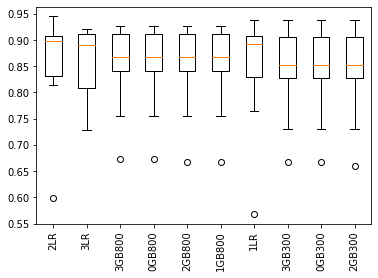

In [7]:
# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# define transform pipelines
pipelines = [pipeline_none, pipeline_QT, pipeline_QT_SS, pipeline_RS_SS]
# evaluate models
results = evaluate_models(X, y, models, pipelines)
# summarize results
summarize_results(results)

<a id='6.2.5'>
    <h2 style='font-size:180%;'>
        Run Time Calculation
    </h2>
</a>

In [53]:
print(f'Finished in {round(time_1-time_0, 0):,} second(s) or {round((time_1-time_0)/60, 0)} minute(s).')

Finished in 2938.53 second(s) or 48.98 minute(s).
